In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 1
%pwd

'/mnt/c/Users/mtr22/code/mre-pinn/notebooks'

In [2]:
import sys, os
import numpy as np
import xarray as xr
import torch
import matplotlib.pyplot as plt

os.environ['DDEBACKEND'] = 'pytorch'
import deepxde

sys.path.append('..')
%aimport mre_pinn

/home/mtr22/anaconda3/envs/MRE-PINN2/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Using backend: pytorch

Loading /mnt/c/Users/mtr22/code/mre-pinn/notebooks/../mre_pinn/__init__.py


In [19]:
# load the MATLAB file
data_root = '../data/BIOQIC'
mat_base = 'four_target_phantom.mat'

mat_file = data_root + '/' + mat_base
data, rev_axes = mre_pinn.data.load_mat_data(mat_file, verbose=True)

Loading ../data/BIOQIC/four_target_phantom.mat
    __header__: <class 'bytes'>
    __version__: <class 'str'>
    __globals__: <class 'list'>
    u_ft: <class 'numpy.ndarray'> (100, 80, 10, 3, 6) complex128


In [65]:
# convert to xarray and add metadata
u_true = data['u_ft'].T
u_dims = ['frequency', 'component', 'z', 'x', 'y']
u_coords = {
    'frequency': 50 + np.arange(u_true.shape[0]) * 10, # Hz
    'x': np.arange(u_true.shape[3]) * 1e-3, # m
    'y': np.arange(u_true.shape[4]) * 1e-3, # m
    'z': np.arange(u_true.shape[2]) * 1e-3, # m
    'component': ['y', 'x', 'z'],
}
u_true = xr.DataArray(u_true, dims=u_dims, coords=u_coords)
u_true = u_true.transpose('frequency', 'x', 'y', 'z', 'component')
u_true = u_true.sel(frequency=[50], z=0, component=['x', 'y'])
u_true

<xarray.DataArray (frequency: 1, x: 80, y: 100, component: 2)>
array([[[[ 4.41610136e-12+4.15293497e-13j,
           1.80392877e-03-2.21015603e-03j],
         [ 2.54974440e-12+1.05876021e-12j,
           1.89734370e-03-2.18494845e-03j],
         [ 0.00000000e+00+0.00000000e+00j,
           1.95992162e-03-2.15976800e-03j],
         ...,
         [ 0.00000000e+00+0.00000000e+00j,
          -1.49606247e-03+8.40557373e-04j],
         [-2.43980266e-12+2.99410724e-14j,
          -1.50236176e-03+8.61343421e-04j],
         [ 0.00000000e+00+0.00000000e+00j,
          -1.50187882e-03+8.89141659e-04j]],

        [[-1.04787094e-04-1.43479483e-05j,
           1.78532489e-03-2.20576001e-03j],
         [-6.69046137e-05-2.64826788e-05j,
           1.87508117e-03-2.18151355e-03j],
         [-3.69753952e-05-3.96238656e-05j,
           1.93444137e-03-2.15399541e-03j],
...
         [ 3.21308950e-04-1.58614413e-03j,
          -1.47214421e-03+3.39784381e-04j],
         [ 2.23235032e-04-1.71146535e-03j,
          -1.21303117e-03+3.22017078e-04j],
         [ 1.53694403e-04-1.84176483e-03j,
          -9.50755081e-04+2.81915877e-04j]],

        [[-2.64239471e-04-1.47929502e-03j,
           7.73650603e-04-9.50628846e-04j],
         [-1.87285939e-04-1.33198412e-03j,
           9.19854132e-04-1.00448328e-03j],
         [-7.52842778e-05-1.16772039e-03j,
           1.08602628e-03-1.04367315e-03j],
         ...,
         [ 4.00781994e-04-1.51666910e-03j,
          -1.57575780e-03+4.54481340e-04j],
         [ 2.91630176e-04-1.68451693e-03j,
          -1.30413755e-03+4.49660820e-04j],
         [ 2.19152692e-04-1.84301455e-03j,
          -1.03910716e-03+4.08667710e-04j]]]])
Coordinates:
  * frequency  (frequency) int64 50
  * x          (x) float64 0.0 0.001 0.002 0.003 ... 0.076 0.077 0.078 0.079
  * y          (y) float64 0.0 0.001 0.002 0.003 ... 0.096 0.097 0.098 0.099
    z          float64 0.0
  * component  (component) <U1 'x' 'y'

In [66]:
%autoreload

batch_size = 1024 # collocation points
num_domain = 1024 # PDE domain samples

# convert to point set boundary condition
bc = mre_pinn.data.NDArrayBC(u_true, batch_size=batch_size)
x = bc.points
x.shape, bc.values.shape

((8000, 3), torch.Size([8000, 2]))

In [67]:
# for single frequency, we need to add eps to the geometry range to avoid zero volume
eps = np.array([1, 0, 0])
x.max(axis=0) - x.min(axis=0) + eps

array([1.   , 0.079, 0.099])

In [68]:
%autoreload

# set up PDE with geometry and boundary condition
residual = mre_pinn.pde.HelmholtzPDE()
geometry = deepxde.geometry.Hypercube(x.min(axis=0) - eps/2, x.max(axis=0) + eps/2)
pde = deepxde.data.PDE(geometry, residual, bc, num_domain=num_domain)
pde.train_x.shape

/home/mtr22/anaconda3/envs/MRE-PINN2/lib/python3.8/site-packages/skopt/sampler/sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+1026=1026. 
  warnings.warn("The balance properties of Sobol' points require "


(2048, 3)

In [88]:
%autoreload

# initialize neural network
net = mre_pinn.model.Parallel([
    mre_pinn.model.ComplexFFN(
        n_input=x.shape[1],
        n_layers=5,
        n_hidden=8,
        n_output=n_output,
        activ_fn=torch.sin,
        w0=8
    ) for n_output in [u_true.shape[-1], 1] # u and mu
])

# standardize inputs to [-1, 1]
x = bc.points
x_loc = np.mean(x, axis=0)
x_scale = (np.max(x, axis=0) - np.min(x, axis=0)) / 2

if x_scale[0] == 0: # single frequency check
    x_scale[0] = 1

# normalize outputs
u = bc.values.cpu().numpy()
u = np.concatenate([u.real, u.imag], axis=1)
u_loc = np.mean(u, axis=0)
u_scale = np.std(u, axis=0)
print(u_scale.shape)

# initialize model weights
net[0].init_weights(input_loc=x_loc, input_scale=x_scale, output_loc=u_loc, output_scale=u_scale)
net[1].init_weights(input_loc=x_loc, input_scale=x_scale, output_loc=5, output_scale=2)

net

(4,)


Parallel(
  (0): ComplexFFN(
    (0): Linear(in_features=3, out_features=8, bias=True)
    (1): Linear(in_features=11, out_features=8, bias=True)
    (2): Linear(in_features=19, out_features=8, bias=True)
    (3): Linear(in_features=27, out_features=8, bias=True)
    (4): Linear(in_features=35, out_features=4, bias=True)
  )
  (1): ComplexFFN(
    (0): Linear(in_features=3, out_features=8, bias=True)
    (1): Linear(in_features=11, out_features=8, bias=True)
    (2): Linear(in_features=19, out_features=8, bias=True)
    (3): Linear(in_features=27, out_features=8, bias=True)
    (4): Linear(in_features=35, out_features=2, bias=True)
  )
)

In [89]:
def msae_loss(y_true, y_pred):
    '''
    Mean squared absolute error.
    '''
    error = torch.abs(y_true - y_pred)
    return torch.mean(error**2)

model = deepxde.Model(pde, net)
model.compile(
    optimizer='adam',
    lr=1e-2,
    loss=msae_loss,
    loss_weights=[1e-10, 1]
)

Compiling model...
'compile' took 0.000153 s



Training model...



<IPython.core.display.Javascript object>


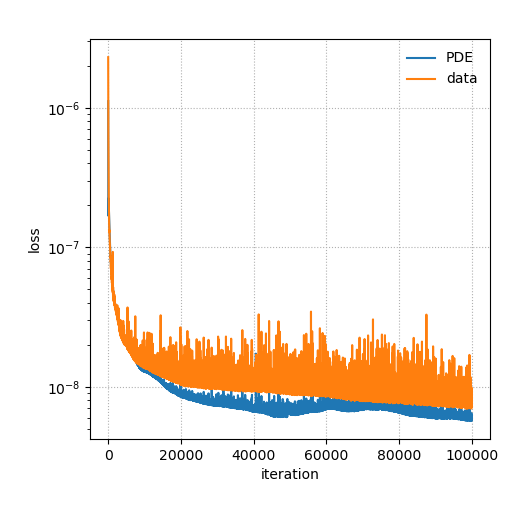


Best model at step 99850:
  train loss: 1.27e-08
  test loss: 1.27e-08
  test metric: []

'train' took 3833.910299 s



In [90]:
deepxde.display.training_display = mre_pinn.visual.TrainingPlot()
try:
    model.train(100000, display_every=10)
except KeyboardInterrupt as e:
    print('Interrupt', file=sys.stderr)

<IPython.core.display.Javascript object>


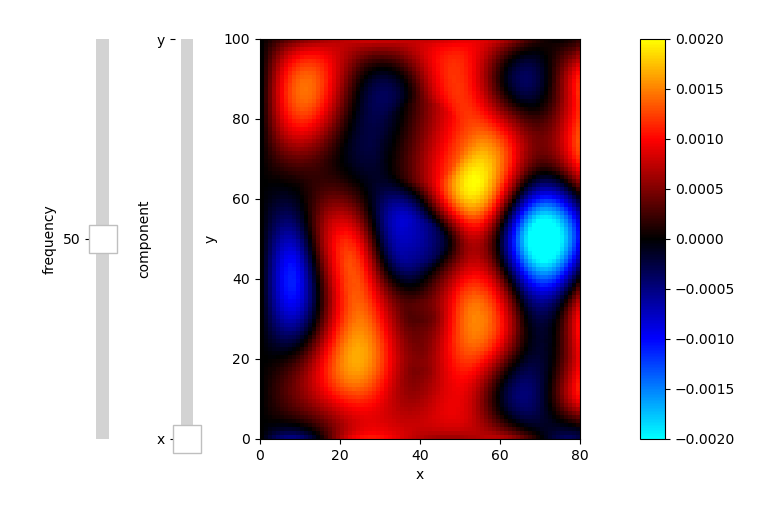

<IPython.core.display.Javascript object>


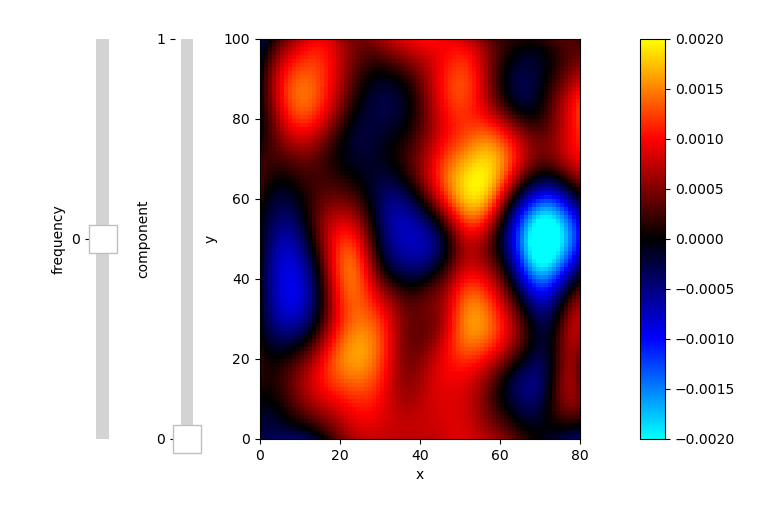

In [91]:
%autoreload

# model predictions
x = bc.points
outputs = model.predict(x)
u_pred = outputs[:,:-1].reshape(u_true.shape)
mu_pred = outputs[:,-1:].reshape(u_true.shape[:-1])
lu_pred = model.predict(
    x, operator=lambda x, y: mre_pinn.pde.laplacian(y[:,:-1], x, dim=1)
).reshape(u_true.shape)

# display wave field
w_map = mre_pinn.visual.wave_color_map()
w_max = 0.002
wave_kws = dict(cmap=w_map, vmin=-w_max, vmax=w_max)

mre_pinn.visual.NDArrayViewer(u_true.real, **wave_kws)
mre_pinn.visual.NDArrayViewer(u_pred.real, labels=u_true.dims, **wave_kws)

<IPython.core.display.Javascript object>


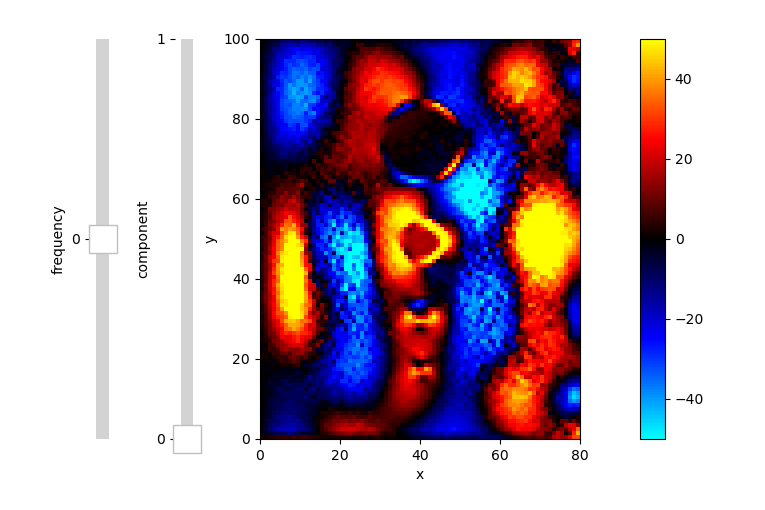

<IPython.core.display.Javascript object>


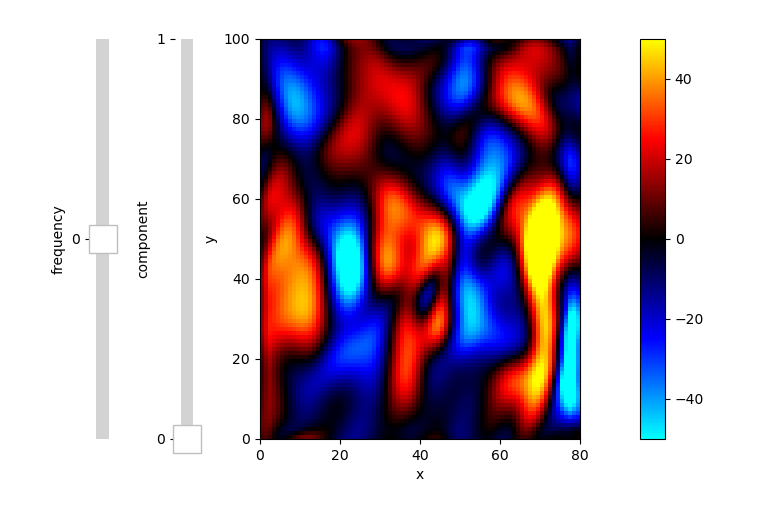

<IPython.core.display.Javascript object>


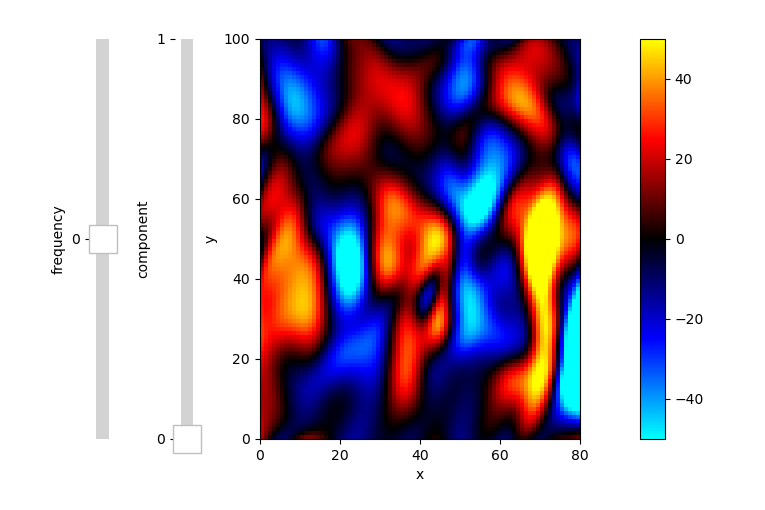

<IPython.core.display.Javascript object>


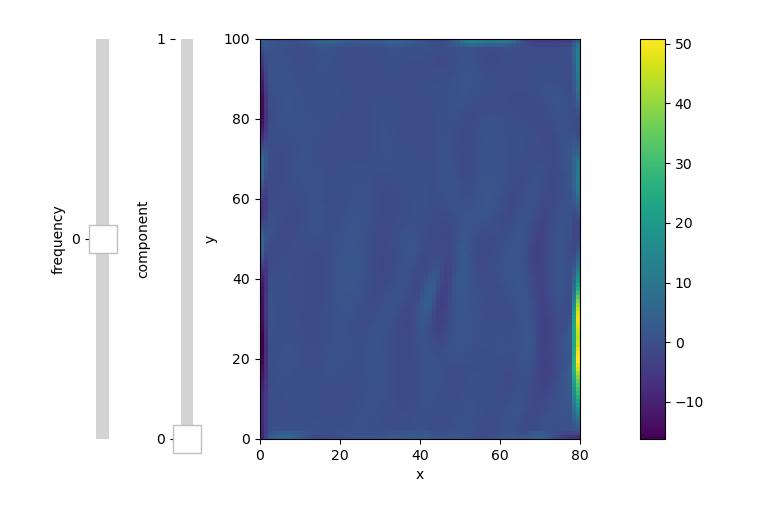

In [92]:
# compute discrete laplacian of wave field

def discrete_laplacian(u, resolution=1, dim=0):
    '''
    Discrete Laplacian operator.
    '''
    components = []
    grad = np.gradient
    for i in range(u.shape[-1]):
        component = 0
        for j in range(dim, len(u.shape) - 1):
            component += grad(grad(u[...,i], axis=j), axis=j) / resolution**2
        components.append(component)
    return np.stack(components, axis=-1)

dx = 1e-3
Lu_true = discrete_laplacian(u_true, resolution=dx, dim=1)
Lu_pred = discrete_laplacian(u_pred, resolution=dx, dim=1)

# display wave field laplacians
L_max = 50
laplace_kws = dict(cmap=w_map, vmin=-L_max, vmax=L_max)

mre_pinn.visual.NDArrayViewer(Lu_true.real, labels=u_true.dims, **laplace_kws)
mre_pinn.visual.NDArrayViewer(Lu_pred.real, labels=u_true.dims, **laplace_kws)
mre_pinn.visual.NDArrayViewer(lu_pred.real, labels=u_true.dims, **laplace_kws)
mre_pinn.visual.NDArrayViewer(Lu_pred.real - lu_pred.real, labels=u_true.dims)

In [94]:
np.linalg.norm(lu_pred - Lu_pred)

3213.4515094442977

<IPython.core.display.Javascript object>


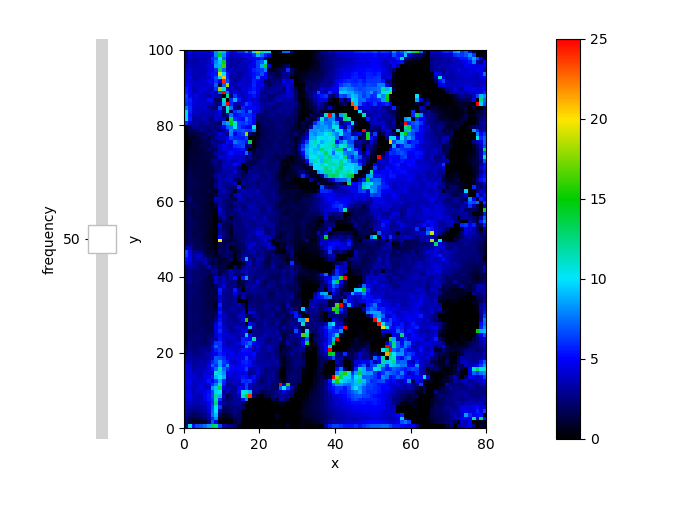

/mnt/c/Users/mtr22/code/mre-pinn/notebooks/../mre_pinn/visual.py:321: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  slider = matplotlib.widgets.Slider(


<IPython.core.display.Javascript object>


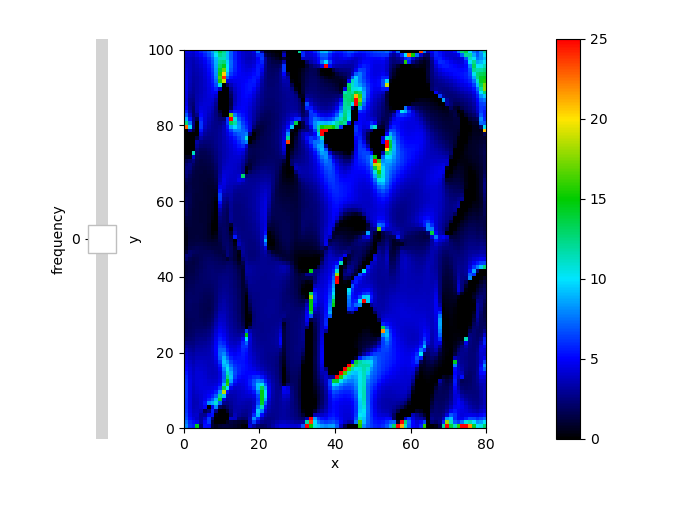

<IPython.core.display.Javascript object>


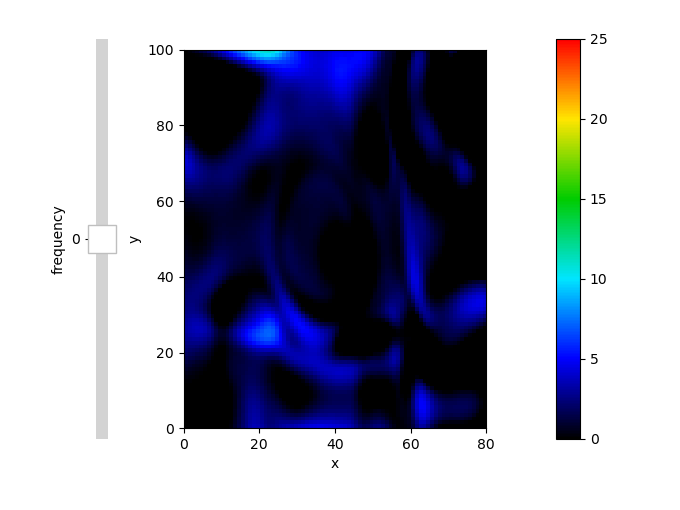

In [95]:
from scipy.ndimage import gaussian_filter

# compare elastograms

def direct_inversion(u, omega, resolution=1, rho=1, dim=0):
    laplace_u = discrete_laplacian(u, resolution, dim=dim)
    return (-rho * (2*np.pi*omega)**2 * u / laplace_u).mean(axis=-1)

#u_filt = gaussian_filter(u_array, sigma=[0, 3, 3])
mu_direct_true = direct_inversion(u_true, omega=float(u_true.frequency), resolution=dx, dim=1)
mu_direct_pred = direct_inversion(u_pred, omega=float(u_true.frequency), resolution=dx, dim=1)

# display elastogram
e_map = mre_pinn.visual.elast_color_map()
e_max = 25
elast_kws = dict(cmap=e_map, vmin=0, vmax=e_max)

mre_pinn.visual.NDArrayViewer(mu_direct_true.real, labels=u_true.dims[:-1], **elast_kws)
mre_pinn.visual.NDArrayViewer(mu_direct_pred.real, labels=u_true.dims[:-1], **elast_kws)
mre_pinn.visual.NDArrayViewer(mu_pred.real,        labels=u_true.dims[:-1], **elast_kws)

In [ ]:
x.shape